In [1]:
using DifferentialEquations, StaticArrays, Plots, Random

┌ Warning: Error requiring `BandedMatrices` from `FiniteDiff`
│   exception = (LoadError("C:\\Users\\Nico\\.julia\\packages\\FiniteDiff\\WOowp\\ext\\FiniteDiffBandedMatricesExt.jl", 1, UndefVarError(:BlockBandedMatrices)), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x00007ffc69e749a1, Ptr{Nothing} @0x00007ffc69eaa8e6, Ptr{Nothing} @0x00007ffc69eca04c, Ptr{Nothing} @0x00007ffc69eaa6fc, Ptr{Nothing} @0x00007ffc69eaaf49, Base.InterpreterIP in top-level CodeInfo for FiniteDiff.FiniteDiffBandedMatricesExt at statement 6, Ptr{Nothing} @0x00007ffc69ec913e, Ptr{Nothing} @0x00007ffc69ec97ec, Ptr{Nothing} @0x00007ffc69ec99a6, Ptr{Nothing} @0x00007ffc69ecac1e, Ptr{Nothing} @0x00007ffc131a91da, Ptr{Nothing} @0x00007ffc130f66a2, Ptr{Nothing} @0x00007ffc129ae746, Ptr{Nothing} @0x00007ffc129ae765, Ptr{Nothing} @0x00007ffc69e9a52a, Ptr{Nothing} @0x0000015d7e2302cf, Ptr{Nothing} @0x0000015d7e2302f6, Ptr{Nothing} @0x00007ffc69ea9cca, Ptr{Nothing} @0x00007ffc69ea970a, Ptr{Nothing} @0x00007ffc6

In [2]:
# Plotting settings
const IN2PX = 96
default(fontfamily="Computer Modern")

In [49]:
# Settings
Random.seed!(1234)

const T = 100 # Total time
const dT = 1e-3 # Integration step

const S = 3  # Num of agents (CS + Retailer)
const N = S + 1 # Num of CS 
const A = 100 # Retailer's availability
const e = 0.99 # Recahrging Efficiency

a = rand(1:0.1:10, S) # EVs' rush
R0 = rand(1:0.1:10, S)
z0 = ones(S)
B0 = rand(100:150, S) .+ 100 # Battery capacity
C0 = rand(10:50, S) # Maximum CSs' power input

# Intital conditions
p0 = zeros(N); p0[N] = A
b0 = rand(S)
x0 = [p0; b0; z0]

par0 = [R0; C0; B0]

9-element Vector{Float64}:
   9.1
   4.2
   4.5
  40.0
  33.0
  39.0
 248.0
 240.0
 225.0

In [50]:
# System 
function EVCC_Dynamic!(dx, x, par, t)
    """
    State vector x := [p,q,z] where 
    - p is the allocated power
    - q is the EVs state-of-charge
    - z is indicates whether the EV nedds power (z = 1) or not

    Parameters vector par := [R,C,B] where
    - R is the maximum CS output power
    - C is the maximum EV power intake
    - B is the EV battery capacity
    """

    # Unpacking
    dp = @view dx[1:N]
    dq = @view dx[N+1:S+N]
    dz = @view dx[S+N+1:2S+N]

    p = @view x[1:N]
    b = @view x[N+1:S+N]
    z = @view x[S+N+1:2S+N]

    R = @view par[1:S]
    C = @view par[S+1:2S]
    B = @view par[2S+1:3S]

    #  Max output and fitness
    P = [min(R, C.*z); A]
    f = [a.*(B .- b) ./ B; 0]

    revision = p'.*max.(P .- p, 0).*max.(f .- f', 0)

    dp .= sum(revision, dims=2) - sum(revision', dims=2)
    dq .= e.*p[1:S]
    dz .= 0

    return nothing
end

# Callbacks
function full_charge(out, u, t, integrator)
    B = @view integrator.p[2S+1:3S]
    b = @view u[N+1:S+N]
    z = @view u[S+N+1:2S+N]
    out .= z .* b .- B
end

function full_charge_jump!(integrator, idx)
    p = @view integrator.u[1:N]
    z = @view integrator.u[S+N+1:2S+N]
    p[N] += p[idx]
    p[idx] = 0
    z[idx] = 0
end

callback = VectorContinuousCallback(full_charge, full_charge_jump!, S)

EVCC_System = ODEProblem(EVCC_Dynamic!, x0, (0,T), par0)
sol = solve(EVCC_System, dt=dT, callback=callback)

 # Unpack state
x = reduce(hcat,sol.u)'
p = @view x[:,1:N]
b = @view x[:,N+1:S+N]
z = @view x[:,S+N+1:2S+N]

f = a'.*(B0' .- b) ./ B0'

59×3 Matrix{Float64}:
 3.89988      5.8951      2.89434
 3.89986      5.89507     2.89433
 3.89982      5.89503     2.89432
 3.89972      5.89495     2.89429
 3.8996       5.89484     2.89424
 3.89941      5.89469     2.89418
 3.89918      5.89451     2.89409
 3.89888      5.89428     2.89398
 3.89859      5.89407     2.89387
 3.89822      5.89379     2.89372
 ⋮                        
 4.46954e-16  0.824206    1.83162e-15
 4.46954e-16  0.358237    1.83162e-15
 4.46954e-16  0.0669978   1.83162e-15
 4.46954e-16  3.4935e-15  1.83162e-15
 4.46954e-16  3.4935e-15  1.83162e-15
 4.46954e-16  3.4935e-15  1.83162e-15
 4.46954e-16  3.4935e-15  1.83162e-15
 4.46954e-16  3.4935e-15  1.83162e-15
 4.46954e-16  3.4935e-15  1.83162e-15

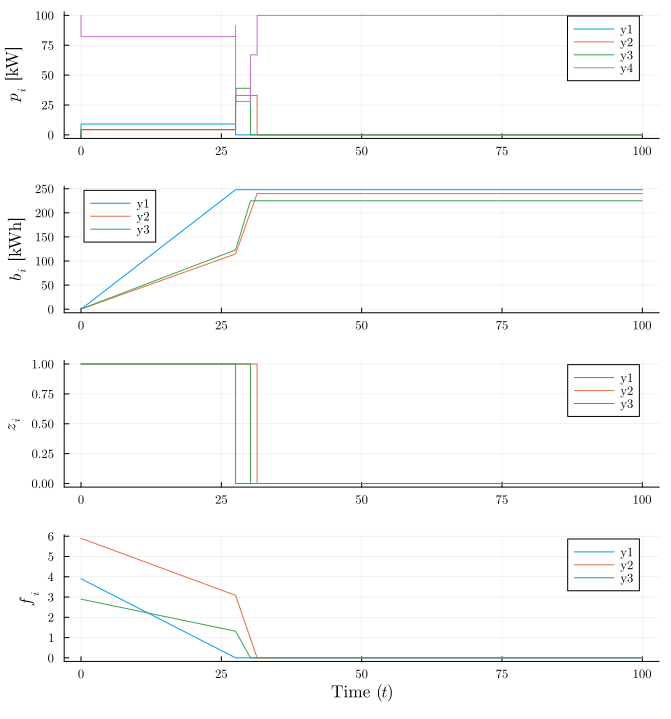

In [51]:
# Plotting 
l = @layout [a; b; c; d] 
plot_power = plot(sol.t, p; ylabel="\$p_i\$ [kW]")
plot_battery = plot(sol.t, b; ylabel="\$b_i\$ [kWh]")
plot_switch = plot(sol.t, z; ylabel="\$z_i\$")
plot_fitness = plot(sol.t, f; xlabel="Time (\$t\$)", ylabel="\$f_i\$")
plot(plot_power, plot_battery, plot_switch, plot_fitness, layout=l, size=(7IN2PX,7.5IN2PX))

In [10]:
B0

2-element Vector{Int64}:
 218
 220

In [9]:
a

3-element Vector{Float64}:
 3.9
 5.9
 2.9

In [13]:
x

16-dimensional StateSpaceSet{Float64} with 151 points
 0.0  0.0  0.0  0.0  0.0  10.0  …  0.920718  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  10.0     0.920718  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  10.0     0.920718  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  10.0     0.920718  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  10.0     0.920718  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  10.0  …  0.920718  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  10.0     0.920718  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  10.0     0.920718  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  10.0     0.920718  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  10.0     0.920718  1.0  1.0  1.0  1.0  1.0
 ⋮                         ⋮    ⋱  ⋮                             ⋮
 0.0  0.0  0.0  0.0  0.0  10.0     0.920718  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  10.0     0.920718  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  10.0     0.920718  1.0  1

In [14]:
a = rand(Float16, 3N)
b, c, d = a[1:N], a[N+1:2N], a[2N+1:3N]

(Float16[0.628, 0.2515, 0.898, 0.9297, 0.867], Float16[0.7383, 0.5356, 0.2192, 0.7344, 0.916], Float16[0.8604, 0.7373, 0.02295, 0.571, 0.722])

In [25]:
sum(b.*max.(0,b.-c'), dims=2)

5×1 Matrix{Float16}:
 0.3145
 0.0081
 1.225
 1.399
 1.076

In [18]:
sum(b)

Float16(3.574)

In [15]:
a = rand(Float16, (3,4))
b, c, d = a[1,1:3], a[2,1:3], a[2,1:3]

(Float16[0.3682, 0.6987, 0.2603], Float16[0.962, 0.03418, 0.8315], Float16[0.962, 0.03418, 0.8315])

In [16]:
a

3×4 Matrix{Float16}:
 0.3682   0.6987   0.2603  0.021
 0.962    0.03418  0.8315  0.977
 0.10693  0.6597   0.749   0.0967